## Import Modules

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Constants

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=120

## Define Dataset and classes

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets",
    shuffle=True,
    image_size = (256, 256),
    batch_size = 32
)
print(dataset)
class_names = dataset.class_names

Found 733 files belonging to 10 classes.
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


2023-07-04 10:32:15.983544: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### calculate the partitions for training, validation, and test datasets
#### Default:
Training = 80%
Validation = 10%
Test = 10%

In [4]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

## Build Model

### Cache, Shuffle, Prefetch, and Data Augmentation

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset


In [9]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

## Compile Model

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/120


2023-07-04 10:32:47.779450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6 of 10000
2023-07-04 10:32:54.865258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2023-07-04 10:32:54.866804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-07-04 10:32:54.881222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


18/18 [==============================] - ETA: 0s - loss: 2.3066 - accuracy: 0.0995

2023-07-04 10:34:22.205638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 10000
2023-07-04 10:34:32.309057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 7 of 10000
2023-07-04 10:34:42.164791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 15 of 10000
2023-07-04 10:34:42.462544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2023-07-04 10:34:42.527920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-07-04 10:34:42.527970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 1000
2023-07-04 10:34:42.553523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


18/18 [==============================] - 128s 6s/step - loss: 2.3066 - accuracy: 0.0995 - val_loss: 2.2941 - val_accuracy: 0.1406
Epoch 2/120
18/18 [==============================] - 105s 6s/step - loss: 2.2432 - accuracy: 0.1361 - val_loss: 2.1766 - val_accuracy: 0.1875
Epoch 3/120
18/18 [==============================] - 104s 6s/step - loss: 1.9788 - accuracy: 0.2216 - val_loss: 1.9902 - val_accuracy: 0.1562
Epoch 4/120
18/18 [==============================] - 121s 7s/step - loss: 1.9005 - accuracy: 0.2513 - val_loss: 1.9796 - val_accuracy: 0.1875
Epoch 5/120
18/18 [==============================] - 124s 7s/step - loss: 1.8790 - accuracy: 0.2461 - val_loss: 1.9494 - val_accuracy: 0.1562
Epoch 6/120
18/18 [==============================] - 222s 12s/step - loss: 1.8671 - accuracy: 0.2653 - val_loss: 1.9404 - val_accuracy: 0.2344
Epoch 7/120
18/18 [==============================] - 191s 10s/step - loss: 1.8213 - accuracy: 0.2513 - val_loss: 1.9726 - val_accuracy: 0.2344
Epoch 8/120
18/1

18/18 [==============================] - 87s 5s/step - loss: 0.2158 - accuracy: 0.9145 - val_loss: 1.0553 - val_accuracy: 0.7500
Epoch 116/120
18/18 [==============================] - 69s 4s/step - loss: 0.2208 - accuracy: 0.9092 - val_loss: 1.2435 - val_accuracy: 0.7812
Epoch 117/120
18/18 [==============================] - 67s 4s/step - loss: 0.3853 - accuracy: 0.8883 - val_loss: 1.2319 - val_accuracy: 0.7188
Epoch 118/120
18/18 [==============================] - 74s 4s/step - loss: 0.4886 - accuracy: 0.8325 - val_loss: 0.7982 - val_accuracy: 0.7812
Epoch 119/120
18/18 [==============================] - 98s 5s/step - loss: 0.3530 - accuracy: 0.8709 - val_loss: 0.6515 - val_accuracy: 0.8281
Epoch 120/120
18/18 [==============================] - 89s 5s/step - loss: 0.2573 - accuracy: 0.9232 - val_loss: 0.6334 - val_accuracy: 0.8594


In [13]:
scores = model.evaluate(test_ds)
scores

2023-07-04 13:27:40.430861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3 of 10000
2023-07-04 13:27:50.407097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 11 of 10000
2023-07-04 13:27:54.302787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2023-07-04 13:27:54.370149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-07-04 13:27:54.370182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 1000
2023-07-04 13:27:54.372731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


3/3 [==============================] - 27s 777ms/step - loss: 0.3360 - accuracy: 0.9247


[0.3360360562801361, 0.9247311949729919]

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Traning and Validation Accuracy and Lose
These graphs shows the loss and the accuracy of the traning and validation dataset

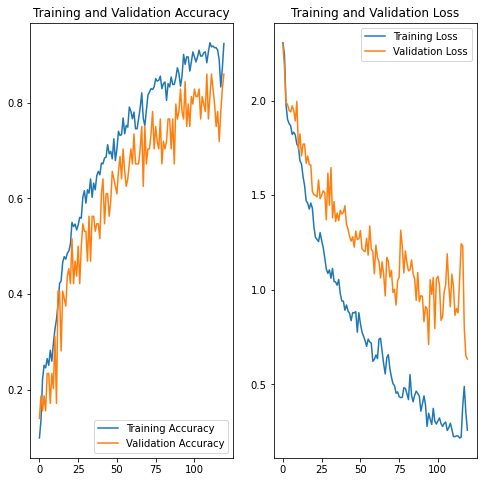

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# A function to predict the image category based on a model
# Returns the predicted class with the confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

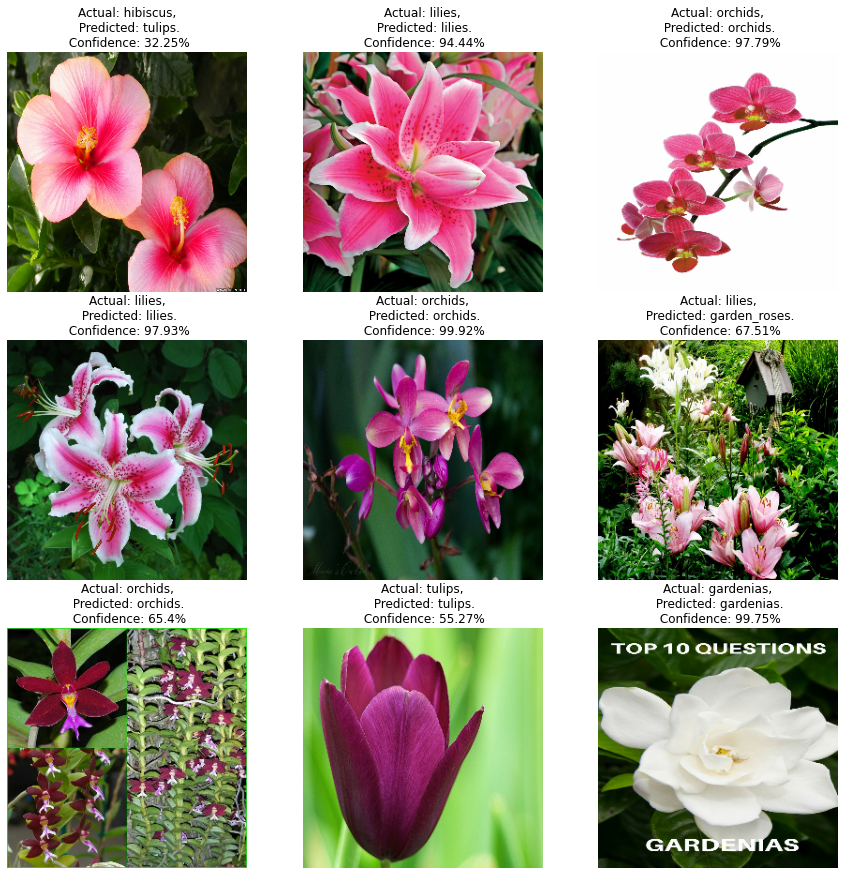

In [18]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Save Model

In [20]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

2023-07-04 13:30:58.165968: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/1/assets
